In [2]:
import torch
%load_ext autoreload
%autoreload 2

In [2]:
import psutil

# Get the virtual memory details
virtual_memory = psutil.virtual_memory()

# Print the total, available, and used memory
print(f"Total memory: {virtual_memory.total / 1e9} GB")
print(f"Available memory: {virtual_memory.available / 1e9} GB")
print(f"Used memory: {virtual_memory.used / 1e9} GB")

Total memory: 14.54618624 GB
Available memory: 12.352708608 GB
Used memory: 1.889529856 GB


autograd calc

In [ ]:
import torch
import scipy.io as sio
from hamiltonians.Central import CentralBdG
from hamiltonians.Lead import Lead
from greens_functions.construct_ginv_total import construct_ginv_total
from calculations.calculation_cf_autograd import calculation_cf_autograd
funcDevice='cpu'
# Define parameters for the central region
Ny = 10  # Number of lattice sites in the y-direction
Nx = 50  # Number of lattice sites in the x-direction
t_y = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Hopping parameter in y-direction
t_x = torch.tensor(1.0, dtype=torch.complex64, device=funcDevice)  # Hopping parameter in x-direction
Delta = torch.tensor(0, dtype=torch.complex64, device=funcDevice)  # Pairing potential for BdG

# Create CentralBdG instance with funcDevice=funcDevice
central_hamiltonian = CentralBdG(Ny=Ny, Nx=Nx, t_y=t_y, t_x=t_x, Delta=Delta)
H_BdG = central_hamiltonian.H_full_BdG  # Get the Hamiltonian matrix on CUDA

# Define parameters for the leads as torch tensors
mu_values = torch.tensor([-20.0, 0.0], dtype=torch.float32, device=funcDevice)  # Chemical potentials for each lead
t_lead_central = torch.tensor(1.0, dtype=torch.float32, device=funcDevice)  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32, device=funcDevice)  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)  # Temperature

# Create lead objects
leads_info = [
    Lead(mu=mu, t_lead_central=t_lead_central, temperature=temperature, Ny=Ny, t_lead=t_lead)
    for mu in mu_values
]

# Set positions for leads, shifting them by one site for Python's 0-based indexing
leads_info[0].position = torch.arange(Ny, device=funcDevice)
leads_info[1].position = leads_info[0].position + Ny * (Nx - 1)

# Define energy and small imaginary part for regularization
# Calculate eigenvalues of H_BdG
eigenvalues = torch.linalg.eigvals(H_BdG).real.sort()[0]  # Sort eigenvalues

# Create base energy grid
E_min, E_max = -3, 3
num_points = 300
base_E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)

# # Create finer subgrids around eigenvalues
# window_size = 0.1  # Size of window around each eigenvalue
# points_per_window = 20  # Number of points in each window
# fine_grid_points = []

# for eigenval in eigenvalues:
#     # Create fine grid around each eigenvalue
#     window_min = float(eigenval) - window_size
#     window_max = float(eigenval) + window_size
#     fine_grid = torch.linspace(window_min, window_max, steps=points_per_window, 
#                               dtype=torch.float32, device=funcDevice)
#     fine_grid_points.append(fine_grid)

# # Combine all grids
# all_grids = [base_E] + fine_grid_points + [eigenvalues]
# combined_E = torch.cat(all_grids)
# Combine all grids
all_grids = [base_E] + [eigenvalues]
combined_E = torch.cat(all_grids)
# Remove duplicates and sort
E, unique_indices = torch.unique(combined_E, sorted=True, return_inverse=True)

eta = torch.tensor(1e-8, dtype=torch.float32, device=funcDevice)  # Small imaginary part for regularization on CUDA

# Process energy values in chunks
chunk_size = 3  # Define the chunk size
results_list = []

for start in range(0, E.size(0), chunk_size):
    end = min(start + chunk_size, E.size(0))
    chunked_E = E[start:end]
    
    # Call the calculation function for the current chunk
    results = calculation_cf_autograd(H_BdG, chunked_E, eta, leads_info, max_derivative_order=2)
    results_list.append(results)

# Combine results from all chunks
combined_results = {
    'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in results_list], dim=0),
    'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in results_list], dim=0),
    'derivatives': {}
}

# Combine derivatives
for order in results_list[0]['derivatives'].keys():
    combined_results['derivatives'][order] = torch.cat([res['derivatives'][order] for res in results_list], dim=0)

# Optionally, save or process the combined results
sio.savemat(f'calculation_results_size_Ny{Ny}_Nx{Nx}_chunkESize_{chunk_size}.mat', combined_results)

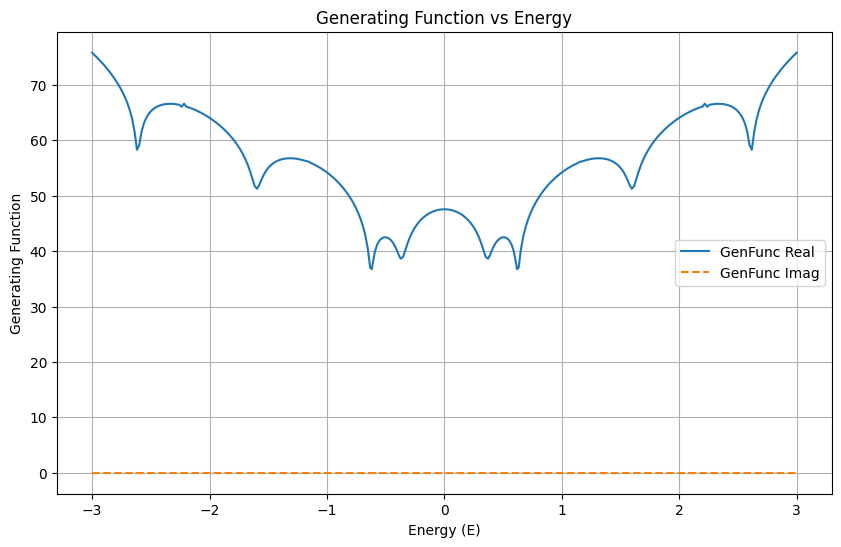

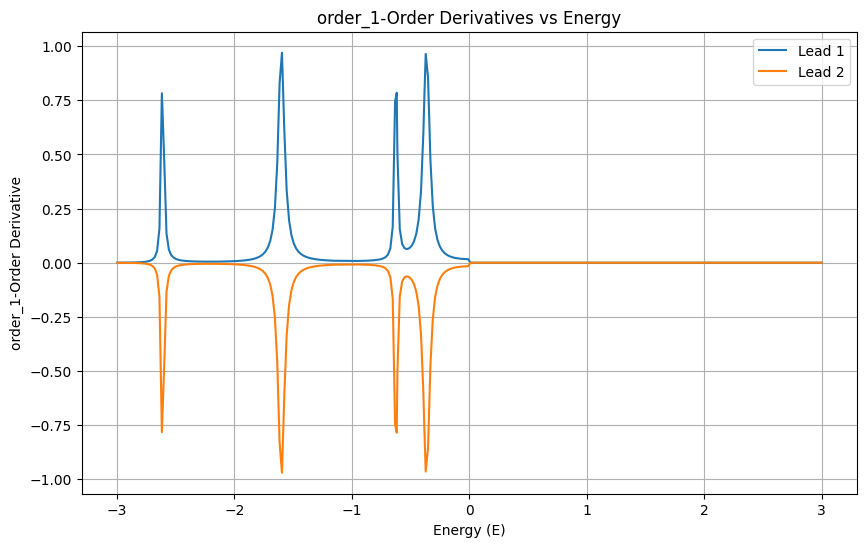

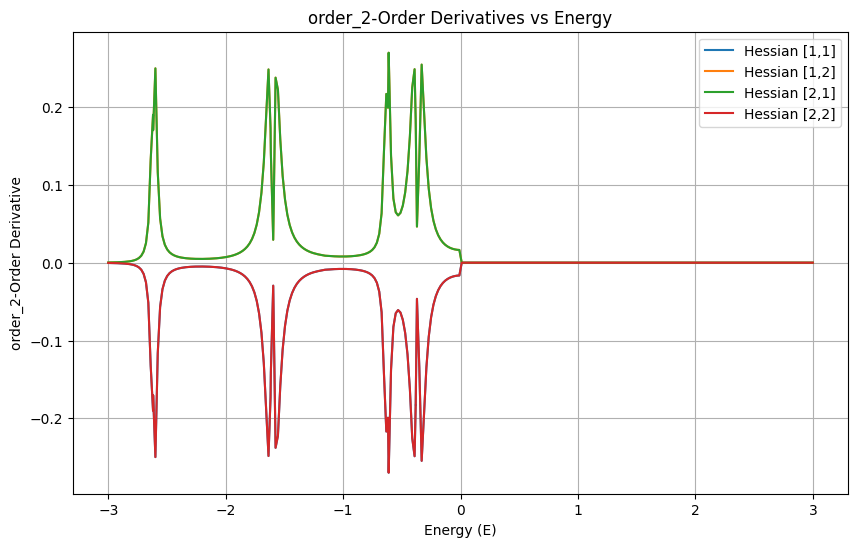

In [8]:
from dataplot.plot_all_gradients import plot_all
# Plot all results
plot_all(combined_results, E)